# SD-TSIA 204 - TP2: Linear Regression

This lab work was made by **Théo Rouvet**. 

We start by importing the relevant libraries.

In [1]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,  Ridge, LassoCV
from sklearn import metrics 
from sklearn.svm import SVR

from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

np.random.seed(4)

## Exercise 1: Data contaminated by the robot

## Question 1

We import the csv file with `pandas`.

In [2]:
diabetes = pd.read_csv("./datadm3.csv", sep = ',', header = None)
print(diabetes.shape)

(442, 211)


We have **$\text{n}$ = 442 patients (i.e. observations), $\text{p}$ = 210 exploratory variables** (the last column being the output variable $Y$). 

## Question 2

We start by extracting the output variable $Y$ and the exploratory variables $X$ from the data set.

In [3]:
Y = diabetes.iloc[:,210] # output variable
X = diabetes.iloc[:,0:210] # exploratory variables
n, p = X.shape 

Having done so, we first check whether the exploratory variables are centered: we calculate their respective means.

In [4]:
mean_X = np.array(X.mean())
min_mean_X, max_mean_X = np.min(mean_X), np.max(mean_X)
print("The means of the exploratory variables range from", min_mean_X, "to", max_mean_X)

The means of the exploratory variables range from -1.7231063232870077e-16 to 7.887104745074642e-17


Considering that the means of the exploratory variables are all lower that $1.73.10^{-16}$ in absolute value, it is rightful to assume that **the exploratory variables are centered**.

We now check whether the exploratory variables are normalized, i.e. whether their standard deviations $\sigma_i$ equal $1$. 

To do so, we compute the quantity $ \text{res} = \|\text{STD} - 1_n \|_2^2$ where :
* $\text{STD}$ is the vector of the standard deviations of the exploratory variables
* $1_n$ is the vector of $n$ lines uniquely containing ones

If $\text{res}$ is low, then we will consider that the exploratory variables are normalized.

In [5]:
STD_X = pd.DataFrame.std(X)
res_X = np.linalg.norm(STD_X - 1, 2)**2
print("The error we obtain is", res_X)

The error we obtain is 0.0002696436177104211


The order of magnitude we obtain is $3.10^{-4}$, so **it is rather sensible to consider that the exploratory variables are normalized as well**.

We then do the same kind of check for $Y$.

In [6]:
print("The mean of Y is", Y.mean())

The mean of Y is 152.13348416289594


Therefore $Y$ is **not centered, hence not normalized**.

To sum up, we have that <FONT color="red"><b> the exploratory variables are centered and normalized </b></FONT> while <FONT color="red"><b> the output variable is not centered (and therefore not normalized) </b></FONT>

We then provide a scatter plot of four randomly chosen exploratory variables and the output variable, using `seaborn`.

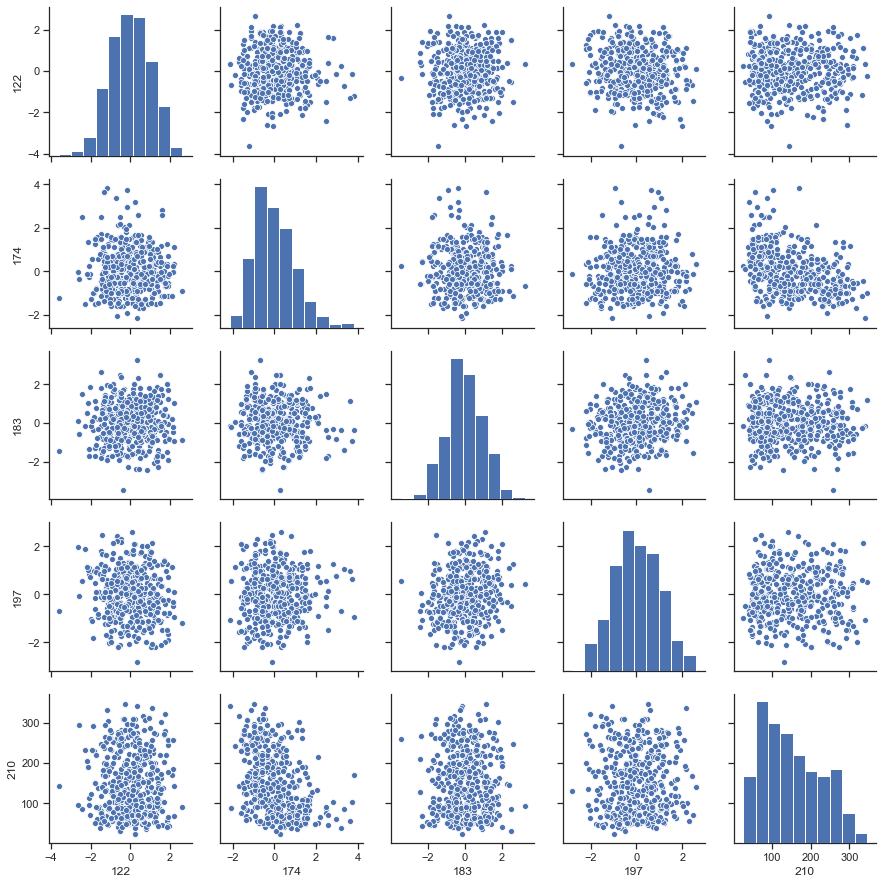

In [7]:
# we randomly pick 4 exploratory variables

i_1 = np.random.randint(0,210)
i_2 = np.random.randint(0,210)
i_3 = np.random.randint(0,210)
i_4 = np.random.randint(0,210)

# plot the chosen exploratory variables and the output variable

sns.set(style = "ticks", color_codes = True)
sns.pairplot(diabetes[[i_1, i_2, i_3, i_4, 210]])

We can see from the graphs that the exploratory variables are neither correlated with each other nor with the output variable. Besides, the diagonal of this pairwise plot indicates that the distribution of the exploratory variables is a (normalized) gaussian. 

## Question 3

We split the data set between a training set (80% of the initial set) and a testing set (20% of the initial set).

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

print("Size of the training set =", X_train.shape[0],"variables")
print("Size of the testing set =", X_test.shape[0],"variables")

Size of the training set = 353 variables
Size of the testing set = 89 variables


## Question 4

We provide the covariance matrix for $X_{\text{train}}$, and plot its eigen values **in descending order**.

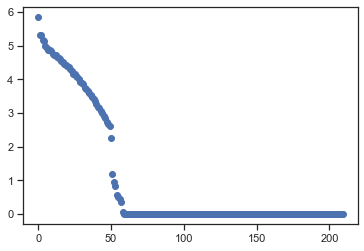

In [9]:
# covariance matrix for X_train
covariance_matrix = pd.DataFrame.cov(X_train)

# computing and sorting eigen values and eigen vectors of covariance matrix
eigen_values, eigen_vectors = np.linalg.eig(np.asarray(covariance_matrix))
indices = eigen_values.argsort()[::-1]
descending_eigen_values, descending_eigen_vectors = np.real(eigen_values[indices]), np.real(eigen_vectors[indices])

# plotting it with a scatter plot
plt.scatter(np.array(range(len(descending_eigen_values))), descending_eigen_values)
plt.show()

Looking at this, we can indeed see that **only a certain number of eigen values are non null**, hence we would like to focus on them as **they convey more significant information**. We can then **consider a PCA** (we would like to eliminate the variables that convey non significant information).

## Question 5

We first do the **"PCA before OLS"**, taking into account the 60 eigen vectors associated with the more significant eigen values.

In [10]:
regr = LinearRegression()

# Training the model
X_new = X_train@descending_eigen_vectors[0:60].T
regr.fit(X_new, y_train)

# Testing the model
y_pred_PCA_OLS = regr.predict(X_test@descending_eigen_vectors[0:60].T)
print("Mean squared error:", metrics.mean_squared_error(y_test, y_pred_PCA_OLS))

Mean squared error: 3022.292634474827


We obtain a quite high mean squared error, so the noise is not completely erased by the PCA. We can test and plot an example to get a more graphical output.

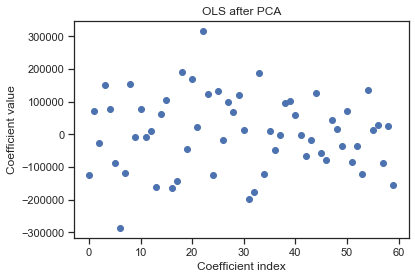

In [11]:
plt.plot(regr.coef_, 'o')
plt.title("OLS after PCA")
plt.ylabel("Coefficient value")
plt.xlabel("Coefficient index")
plt.show()

We then provide the classical OLS taking all the exploratory variables into account.

In [12]:
# Classical OLS
regr_2 = LinearRegression()

# Training the model
regr_2.fit(X_train, y_train)

# Testing the model
y_pred_classical_OLS = regr_2.predict(X_test)
print("Mean squared error:", metrics.mean_squared_error(y_test, y_pred_classical_OLS))

Mean squared error: 3364.1398951749893


We can note a **higher mean squared error** than the previous version (the one with PCA beforehand). We can then try and plot it as well to understand the extent of this.

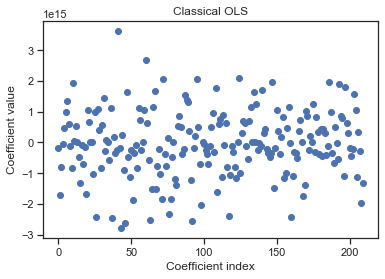

In [13]:
plt.plot(regr_2.coef_, 'o')
plt.title("Classical OLS")
plt.ylabel("Coefficient value")
plt.xlabel("Coefficient index")
plt.show()

## Question 6

In [14]:
print("The intercept for the 'PCA before OLS' is",regr.intercept_)
print(" ")
print("The intercept for the 'classical OLS' is", regr_2.intercept_)
print(" ")
print("Mean value of Y:", np.mean(y_train))

The intercept for the 'PCA before OLS' is 152.37711906996003
 
The intercept for the 'classical OLS' is 151.5322680594901
 
Mean value of Y: 151.1416430594901


The intercepts for the two OLS (with and without PCA) are **different**, and also **different from the mean value of the output Y**, which confirms that the data we work with is not centered and normalized.

We then center and normalize the variables after PCA (and check the correctness of this operation).

In [15]:
# Centering and normalizing the variables after PCA
X_new_norm = (X_new-np.mean(X_new))/np.std(X_new)

# Checking that we have correctly centered
mean_X_new_norm = np.mean(X_new_norm)
min_mean_X_new_norm, max_mean_X_new_norm = np.min(mean_X_new_norm), np.max(mean_X_new_norm)
print("The means of the exploratory variables after PCA range from", min_mean_X_new_norm, "to", max_mean_X_new_norm)

# Checking that we have correctly normalized
residual_X_new_norm = np.linalg.norm(np.std(X_new_norm) - 1, 2)**2
print("The error we obtain is", residual_X_new_norm)

The means of the exploratory variables after PCA range from -8.476065301316705e-17 to 7.265198829700033e-17
The error we obtain is 1.0871489350077068e-29


The results we obtain for the mean and the standard deviation indicate that **we have correctly centered and normalized the variables after PCA** (same check as in question 2). We now run a new regression with these variables and check the value of the intercept.

In [16]:
regr_3 = LinearRegression()

# Training the model
regr_3.fit(X_new_norm, y_train)

# Centering and normalizing the test set
X_test_new = X_test@descending_eigen_vectors[0:60].T
X_test_new_norm = (X_test_new-np.mean(X_test_new))/np.std(X_test_new)

# Testing the model
y_pred = regr_3.predict(X_test_new_norm)
print("The intercept for this model is", regr_3.intercept_)
print("The mean value of Y we computed earlier was", np.mean(y_train))

The intercept for this model is 151.14164305946628
The mean value of Y we computed earlier was 151.1416430594901


As a result, we do  verify that **the intercept is equal to the average of $Y$ on the training set**, having normalised and centered the variables after PCA.

## Question 7

We wish to check the significance of the two OLS we conducted earlier. 

We define **the residual of the prediction** for the test sample as the **pointwise distance between the actual values corresponding to the test sample and the values that the regression predicted** : $\forall i, \text{ } \text{residual}_i = | y_{\text{pred}_i} - y_{\text{test}_i} | $.

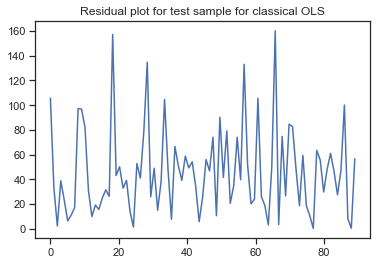

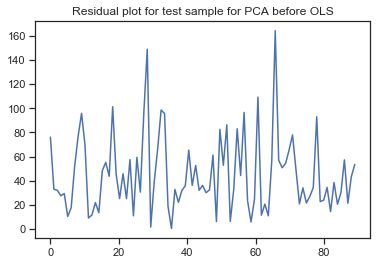

In [17]:
abscissa_tab = np.linspace(0, len(y_test), len(y_test)) # for the following plots

# Classical OLS residual
residual_classical_OLS = np.abs(y_pred_classical_OLS - y_test)
plt.plot(abscissa_tab, residual_classical_OLS)
plt.title("Residual plot for test sample for classical OLS")
plt.show()

# PCA before OLS residual
residual_PCA_OLS = np.abs(y_pred_PCA_OLS - y_test)
plt.plot(abscissa_tab, residual_PCA_OLS)
plt.title("Residual plot for test sample for PCA before OLS")
plt.show()

We then use histograms to plot the density of the residuals.

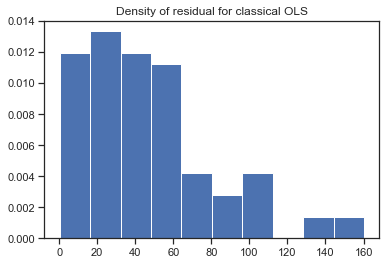

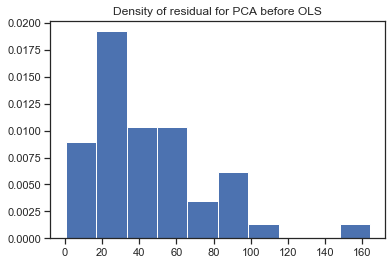

In [18]:
# Classical OLS
plt.hist(residual_classical_OLS, density = True)
plt.title("Density of residual for classical OLS")
plt.show()

# PCA before OLS
plt.hist(residual_PCA_OLS, density = True)
plt.title("Density of residual for PCA before OLS")
plt.show()

We then compute the determination coefficients and the prediction risk for the two OLS, before comparing them.

We remind the definitions of these two quantities:
* Determination coefficient (which we will compute using `sklearn.score`): $$ R^2 = 1- \frac{\|y_{\text{pred}} - y_{\text{test}} \|^2_2}{\|y_{\text{pred}} - \overline{y_{\text{test}}} \|^2_2} $$
* Prediction risk: $$R_{\text{pred}}(y_{\text{pred}}, y_{\text{test}}) = \frac{\mathbb{E}[\|y_{\text{pred}} - y_{\text{test}} \|^2_2]}{n} \text{  }\text{ where $n$ is the length of the test sample}$$ 

In [19]:
# Classical OLS
R2_classical_OLS = regr_2.score(X_test, y_test)
prediction_risk_classical_OLS = (residual_classical_OLS@residual_classical_OLS.T)/len(y_test)
print("Determination coefficient for classical OLS =", R2_classical_OLS)
print("Prediction risk for classical OLS =", prediction_risk_classical_OLS); print(" ")

# PCA before OLS
R2_PCA_OLS = regr.score(X_test_new, y_test)
prediction_risk_PCA_OLS = (residual_PCA_OLS@residual_PCA_OLS.T)/len(y_test)
print("Determination coefficient for PCA before OLS =", R2_PCA_OLS)
print("Prediction risk for PCA before OLS =", prediction_risk_PCA_OLS)

Determination coefficient for classical OLS = 0.41245640975236075
Prediction risk for classical OLS = 3364.1398951749893
 
Determination coefficient for PCA before OLS = 0.4721596840294391
Prediction risk for PCA before OLS = 3022.292634474828


From all this question, **we can conclude that <FONT color="red"><b>using a PCA before OLS is more efficient</b></FONT> than using the classical OLS on the whole data set**. 

Indeed, doing so **lowers the prediction risks and increases the determination coefficient** of the regression. 

Besides, we note that the distribution of the residual of the prediction for the test sample is overall more concentrated around low values in that case. This accounts for the fact that the residual of the prediction for the test sample is more likely to be low. The prediction is therefore close to the test values, which is again a sign of a more efficient prediction.

## Question 8

In this question, we implement the **forward variable selection method**.

First, we include the intercept in $X$, adding a column of ones to the matrix : $(1_n, X)$.

In [20]:
X_with_intercept = np.column_stack((np.ones((n, 1)), np.array(X)))

Having done so, we implement the algorithm. We will try to stick to the notations used in the lecture notes.

The first step is a proper **initialization of the algorithm**, along with a new calculus of the regression (that includes the intercept).

In [21]:
r = np.array(Y)
A, S = list(range(p)) , []

# We will stock the test statistics and the p-values
test_stat, p_values = np.zeros((p,p)), np.zeros((p,p))
freedom_degrees = n - p - 1

reg_new = LinearRegression(fit_intercept = False) # intercept already taken into account in X_with_intercept

Then, we perform the forward variable selection until all the variables get selected.

We remind that $ \hat{\sigma}^2_n = \frac{\sum_{i=1}^n (Y_i−X^T_i\hat{θ}_n)^2}{(n−p−1)} = \frac{\|Y−X^T\hat{θ}_n\|^2_2}{(n−p−1)} $. The numerator is in fact the updated version of the residual. We also remind that $\hat{s}^2_{n,k}$ is the $k$-th term in the diagonal of $\hat{G}^{−1}_n$.

In [22]:
for k in range(p):
    
    next_r = np.zeros((n,p))
    
    for var in A:
        
        var = int(var)
        reg_new.fit(X_with_intercept[:,[var]], r) # train the model for each covariate
        next_r[:,var] = r - reg_new.predict(X_with_intercept[:,[var]]) # update the residual
        slope = np.abs(reg_new.coef_)
        
        # Test of no effect (student-t test)
        
        s_nk_hat = np.sqrt(n)/np.linalg.norm(X_with_intercept[:,var],2)
        sigma_n_hat = np.linalg.norm(next_r[:,var],2)/np.sqrt(freedom_degrees)
        denominator = s_nk_hat * sigma_n_hat
        
        test_stat[k, var] = (np.sqrt(n)*slope) / denominator
        p_values[k, var] = 2*(1-stats.norm.cdf(test_stat[k,var]))
    
    k_star = np.argmax(test_stat[k,:])
    A.remove(k_star)
    S.append(k_star)
    r = next_r[:,k_star]

Eventually, we can print the final set S, so as to see the order in which variables are selected by the algorithm.

In [23]:
print("Order of the variable selection :")
print(np.array(S))

Order of the variable selection :
[  0  59 124 134 168 130  32  14   6 136 184 209 175  86  46 185 131  30
  20  36  29  98  96  94 191 116   5 121  19 100  35  80  50 132 207 151
 165 117 195 111 143 122  76 202  78  41 119  93 160   8  69  60  11  12
 186  51 189  75  40 147   7  10  39 161 141 163 181  74 120 190  38 108
  68  90 194  70 158 173 101 142 204 188  22 123 113  48  92 180 192 105
 149  66 199 115 183 128   9 171  16  82  34  95 159  58  27 150  33 200
 155  64  43 139 145 177 127  91 112 104 140  84 138  61   3  62 154 197
  17 114 203 178   1 162 148  55  67  25 170 196  42  56  31  85  79 176
  54  87  88  45  77 182 152  65  97  57 201  81 118 193  99 109 125  73
  37 179  24 174 157  15  72  18  23  89 187  83  53  44 156  28 166   2
 205 133 110 102   4 208 103 137 144 106 206 153  49  21 129 146  52  13
  71 198 107 126  26 164  63 135 169 172  47 167]


## Question 9

We have defined the stop criterion as being the p-value larger than 0.1. We start by **plotting the values of the test statistics as a function of the features** (i.e. the variables considered, since each variable represents a certain feature).

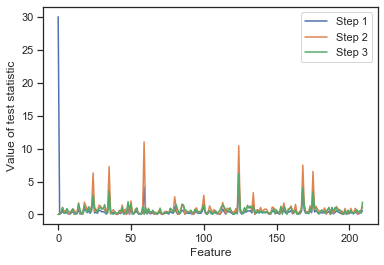

In [24]:
tab = np.array(range(p))

plt.plot(tab,test_stat[0,:], label = "Step 1")
plt.plot(tab,test_stat[1,:], label = "Step 2")
plt.plot(tab,test_stat[2,:], label = "Step 3")

plt.xlabel("Feature")
plt.ylabel("Value of test statistic")
plt.legend()
plt.show()

We then **plot the p-values from the forward variable selection algorithm** and check which one should be selected with the stopping criterion.

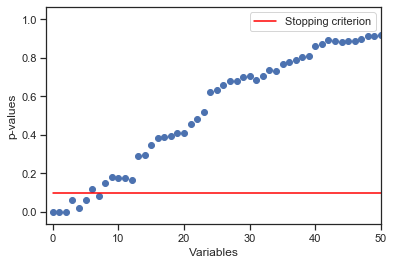

In [25]:
# Getting the p-values
values = []
for (i, var) in enumerate(S):
    values.append(p_values[i,var])
values = np.array(values)

# Plotting the p-values
plt.scatter(tab, values)
plt.plot(tab, [0.1]*len(tab), color = "red", label = "Stopping criterion")
plt.axis(xmin = -1, xmax = 50) # we only consider the 50 first p-values
plt.ylabel("p-values")
plt.xlabel("Variables")
plt.legend()
plt.show()

According to this, we provide the list of the selected variables, i.e. the list of the variables that observe the stopping criterion.

In [26]:
selected_variables = np.array(S)[values<0.1]
print("Selected variables indices :" , selected_variables)

Selected variables indices : [  0  59 124 134 168 130  14]


We then have reduced the problem to only a few variables, whereas the data set originally contains 210 exploratory variables. Therefore, the **forward variable selection method** with a **stopping criterion based on a test of no effect** has permitted a <FONT color="red"><b>tremendous dimensional reduction</b></FONT>, and perhaps selecting the best variables which convey most information.

## Question 10

We now run a new OLS on these variables, after removing the intercept that we needed to include for the forward variable selection method (i.e. removing the first column of ones).

Determination coefficient: 0.5610626787448175
Prediction risk: 2513.2544689891342


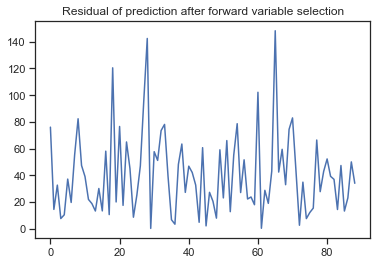

In [27]:
indices_forward = selected_variables[1:]-1 # getting rid of the intercept
X_train_forward_sel = X_train[indices_forward]

ols_forward_sel = LinearRegression()
ols_forward_sel.fit(X_train_forward_sel, y_train)

y_pred_forward_sel = ols_forward_sel.predict(X_test[indices_forward])
residuals_forward_sel = np.abs(y_pred_forward_sel - y_test)

print("Determination coefficient:", ols_forward_sel.score(X_test[indices_forward], y_test))
print("Prediction risk:", np.dot(residuals_forward_sel, residuals_forward_sel.T)/len(y_test))

plt.plot(range(len(y_test)), residuals_forward_sel)
plt.title("Residual of prediction after forward variable selection")
plt.show()

This is the best result that we have obtained so far, both in terms of determination coefficient and prediction risk. As a result, <FONT color="red"><b>OLS run on selected variables is more efficient than PCA before OLS and classical OLS</b></FONT>. However, the computing time is not trivial (especially is terms of memory cost).

## Question 11

In order to prepare for cross-validation, we randomly split the train sample in 4 equal parts (called "folds"). We then provide the number of observations falling into each fold.

In [28]:
n_folds = 4
n_train = X_train.shape[0]

indices = np.array(X_train.index)
np.random.shuffle(indices)

sels = []

for k in range(n_folds):
    sels.append(indices[int((n_train)/n_folds*k):int((n_train)/n_folds*(k+1))])

x_sel = []
y_sel = []

for i in range(n_folds):
    x_sel.append(X_train.loc[sels[i]])
    y_sel.append(y_train[sels[i]])
    print("Set number", str(i+1)+ ":", sels[i].shape[0], "observations")

Set number 1: 88 observations
Set number 2: 88 observations
Set number 3: 88 observations
Set number 4: 89 observations


We have splitted the data set into 4 equally-sized folds, which will be useful for cross-validation to get a proper parameter for the Ridge method. 

## Question 12

We implement the <FONT color="red"><b>Ridge method</b></FONT>, which consists in minimizing the quantity $ \|Y - X\theta\|^2_2 + n\lambda\|\theta\|^2_2$.

Firstly, we need to determine the **best value for the regularization parameter $\lambda$, using a cross-validation method** (thanks to the folds defined in question 11).

In [29]:
# provide a great variety of possible parameters : from 0.001 to 1000
lmbda = [i * 10**j for j in range(-3,3) for i in range(1,10)]+[1000]

risk = np.zeros(len(lmbda))
score = np.zeros(len(lmbda))

for k in range(n_folds):
    x_train_k = pd.concat([x_sel[i] for i in range(n_folds) if i != k ])
    y_train_k = pd.concat([y_sel[i] for i in range(n_folds) if i != k ])
    x_test_k = x_sel[k]
    y_test_k = y_sel[k]
    
    for i in range(len(lmbda)):
        ridge_k = Ridge(lmbda[i]).fit(x_train_k, y_train_k)
        risk[i] += np.sum((ridge_k.predict(x_test_k) - y_test_k)**2)/len(y_test_k)
        score[i] += ridge_k.score(x_test_k,y_test_k)

We have built an array representing the risk as a function of the regularization parameter $\lambda$. Let us plot it to see what would be an efficient $\lambda$.

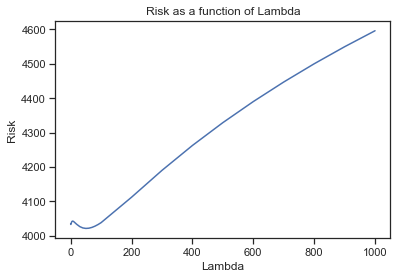

In [30]:
plt.plot(lmbda, risk/n_folds)
plt.ylabel("Risk")
plt.xlabel("Lambda")
plt.title("Risk as a function of Lambda")
plt.show()

Let us zoom on the area where $\lambda$ seems to minimize the risk:

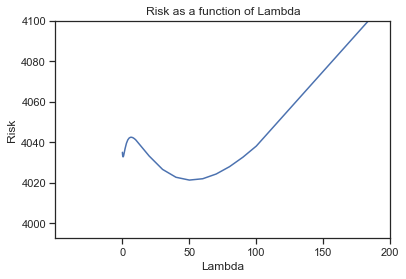

In [31]:
plt.plot(lmbda, risk/n_folds)
plt.axis(xmax = 200, ymax = 4100)
plt.ylabel("Risk")
plt.xlabel("Lambda")
plt.title("Risk as a function of Lambda")
plt.show()

It appears that $\lambda = 50$ seems to be a relevant choice.

In [32]:
minimum_risk = min(risk)/n_folds
lambdda = lmbda[np.argmin(risk)]

score_lambda = score[np.argmin(risk)]/n_folds
score_max = max(score)/n_folds

print("Chosen parameter:", lambdda)
print("Risk associated:", minimum_risk)
print("Determination coefficient associated:", score_lambda)
print(" ")
print("Maximum determination coefficient:", score_max)

Chosen parameter: 50
Risk associated: 4021.395799370398
Determination coefficient associated: 0.3233186115227568
 
Maximum determination coefficient: 0.3233186115227568


This confirms that we should choose $\lambda = 50$. **We can now apply the Ridge method on the test sample, as we have given a value to the regularization parameter (it is fixed now)**.

In [33]:
ridge = Ridge(lambdda)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("Prediction risk:", np.sum((y_pred_ridge - y_test)**2)/len(y_test))
print("Determination coefficient:", ridge.score(X_test, y_test))

Prediction risk: 2824.063504268608
Determination coefficient: 0.5067801987767815


The Ridge method hence yields a rather **good result** (both in terms of prediction risk and determination coefficient). It is in fact, so far, the second best after OLS run on variables selected with forward variable selection method.

## Question 13

The LASSO works with the same principle as the Ridge estimator, with a different norm : minimizing $ \frac{1}{2}\|Y - X\theta\|^2_2 + \lambda\|\theta\|_1$. We work with 4 folds again, so the method should look for the best parameter (with cross-validation) for `cv = 4`.

In [34]:
lasso = LassoCV(cv = 4).fit(X_train, y_train)

We then have a look at the results for the LASSO: the chosen parameter, and the corresponding risk and determination coefficient.

In [35]:
print("Chosen parameter :",lasso.alpha_)
print("Prediction risk :", np.sum((lasso.predict(X_test) - y_test)**2)/len(y_test))
print("Determination coefficient :", lasso.score(X_test, y_test))

Chosen parameter : 5.852969440781527
Prediction risk : 2791.852337009677
Determination coefficient : 0.5124058461776293


As a result, the **LASSO is rather efficient as well** (second in terms of prediction risk and determination coefficient).

## Question 14

We check which variables were selected by the LASSO:

In [36]:
lasso_vars = [i for i in range(len(lasso.coef_)) if (lasso.coef_[i] != 0)]
print("Number of selected variables =", len(lasso_vars))

Number of selected variables = 7


Thus, the LASSO has selected 7 variables. We then wish to run a linear regression on them and check the results that we get (with the Least-square LASSO).

In [37]:
OLS_Lasso = LinearRegression()
OLS_Lasso.fit(X_train[lasso_vars], y_train)

print("Prediction risk:",np.sum((OLS_Lasso.predict(X_test[lasso_vars]) - y_test)**2)/len(y_test))
print("Determination coefficient:", OLS_Lasso.score(X_test[lasso_vars], y_test))

Prediction risk: 2827.1731382624835
Determination coefficient: 0.506237104381766


There again, we obtain a prediction risk below 3000 and a determination coefficient above 0.5, hence **the Least-square LASSO is rather efficient as well**, but still a bit less efficient here than the variables selected at question 9.

## Question 15

We now have an outlook for the non-linear approach. We split the set into 4 folds again, and **we keep only the variables selected with the forward variable selection** (since it gave us the best results).

In [38]:
sel = np.array(X_train.index)
np.random.shuffle(sel)

sels = []

for k in range(n_folds):
    sels.append(sel[int((n_train)/n_folds*k):int((n_train)/n_folds*(k+1))])

X = []
Y = []

# Using the variables selected by the forward variable selection
for k in range(n_folds):
    X.append(X_train[indices_forward].loc[sels[k]])
    Y.append(y_train[sels[k]])
    print(str(k+1)+"th set :", sels[k].shape[0], "observations")

1th set : 88 observations
2th set : 88 observations
3th set : 88 observations
4th set : 89 observations


Then, we implement a cross validation for the parameters we choose: $C$ and $\epsilon$ for the Epsilon-Support Vector Regression (`sklearn.svm.SVR`, a non-linear regression).

In [39]:
C_list = [i * 10**j for j in range(-3,3) for i in range(1,10)]
eps = [i * 10**j for j in range(-3,3) for i in range(1,10)]

risk = np.zeros((len(C_list), len(eps)))
score = np.zeros((len(C_list), len(eps)))

for k in range(n_folds):
    x_train_k = pd.concat([X[i] for i in range(n_folds) if i != k ])
    y_train_k = pd.concat([Y[i] for i in range(n_folds) if i != k ])
    x_test_k = X[k]
    y_test_k = Y[k]
    
    for i in range(len(C_list)):
        for j in range(len(eps)):
            svr_k = SVR(gamma = 'scale', C = C_list[i], epsilon = eps[j])
            svr_k.fit(x_train_k, y_train_k)
            risk[i,j] += np.sum((svr_k.predict(x_test_k) - y_test_k)**2)/len(y_test_k)
            score[i,j] += svr_k.score(x_test_k,y_test_k)

We then look at the **usual risk and determination coefficient**, after learning on the train folds.

In [40]:
risk_min = np.min(risk)/n_folds
arg_min = np.argmin(risk)
i,j = arg_min//len(C_list), arg_min%len(C_list)
C = C_list[i]
epsilon = eps[j]
score_C_eps = score[i,j]/n_folds
score_max = np.max(score)/n_folds

print("Chosen parameters:", "C =", C, "and Epsilon =", epsilon)
print("Risk associated:", risk_min)
print(" ")
print("Determination coefficient associated:", score_C_eps)
print(" ")
print("Maximum determination coefficient:", score_max)

Chosen parameters: C = 20 and Epsilon = 3
Risk associated: 3426.222181004623
 
Determination coefficient associated: 0.4174638166999016
 
Maximum determination coefficient: 0.4174638166999016


To conclude, we **test the trained model on the testing set**:

In [41]:
svr = SVR(gamma = 'scale', C = C, epsilon = epsilon).fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

print("Risk :", np.sum((y_pred_svr - y_test)**2)/len(y_test))
print("Determination coefficient :", svr.score(X_test, y_test))

Risk : 4592.8410749525265
Determination coefficient : 0.19786500600502843


We then can see that the model we trained worked much better on the training set than on the test set. Therefore, we can suspect overfitting ("sur-apprentissage") on the training set. We can also note that it is longer to compute.

Overall, <FONT color="red"><b>the linear models seem to work better</b></FONT> so as to recover the significant variables, before the robot added noise to the set. 